# Dendrite pre-processing and ROI generating

* Describe the data using ML techniques, maybe pointilistically, thereby allowing use of **pointnet++ models**
* otherwise give a cleaner preprocessed data view, as input to a **custom big voxel 3d DNN Network**

In [1]:
%matplotlib inline

## Demo Sigmoid, fiber clustering

We have several different imaging stack types:

* 2 photon crisp looking images
* Emmited photon imaging
* Transmited photon imaging


We can start by simply applying the filter:

* $Pix'_{xyz} =  1/(1+2.718^{( Pix_{xyz} -255^2   )/255^2 }) $ 


For 2p images, we can get a good cleaned image stack, 
where the *light* signal is strenghtened, 
while the *black* background is minimized

with a sigmoid pixel distribution...

<Container object of 100 artists>

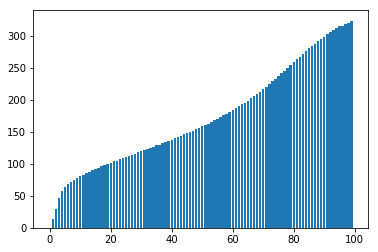

In [2]:
import matplotlib.pyplot as plt

from skimage import io
import numpy as np

cc=('/home/kiks/projects/Dendrites/data/rZn09a.09Atlas_Cyc10_607em_STK_decon_mathes___div in sig_THRES.tif')

dd = io.imread(cc)

percs=np.percentile(dd,np.arange(100))

plt.bar(range(100),percs)






In [3]:
PIXEL_INTENSITY_THRESHOLD = 50


ax,ay,az = np.where(dd<PIXEL_INTENSITY_THRESHOLD)



print('{:.3f}% of stack size is thresholded as signal'.format(ax.shape[0]/np.product(dd.shape)))

0.032% of stack size is thresholded as signal


In [4]:
dd.shape

(599, 1024, 1024)

### watershed processing

In [5]:
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

def makeas(img,ax,ay,az):
    zeroR = np.zeros(img.shape,dtype=img.dtype)
    zeroR[ax,ay,az] = 1
    return zeroR




In [6]:
subs = dd[400:600,100:600,200:800]

# from skimage.feature import peak_local_min
mask_maxi = (subs<50).astype(bool)
ax,ay,az = np.where(subs<50)
choices = np.random.choice(ax.shape[0],80,replace=False)

maxs_small = makeas(subs,ax[choices],
                    ay[choices],az[choices])


# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(mask_maxi
                                     )
# local_maxi = peak_local_max(distance.max()-distance, indices=False, footprint=np.ones((3, 3)),
#                             labels=subs)




markers = ndi.label(maxs_small)[0]
labels = watershed(-distance, markers, mask=subs)

labels.shape

(199, 500, 600)

In [61]:
io.imsave('img_sub2.tif',subs)

/home/kiks/miniconda3/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: img_sub2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [15]:
io.imsave('img_labels3.tif',labels)

/home/kiks/miniconda3/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: img_labels3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [16]:
io.imsave('img_distance2.tif',distance.astype(np.uint8))

/home/kiks/miniconda3/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: img_distance2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [ ]:
io.imsave('img_maskmax.tif',mamask_maximaxi)

In [11]:
mask_maxi = (subs<50).astype(bool)
ax,ay,az = np.where(subs<50)
choices = np.random.choice(ax.shape[0],80,replace=False)

maxs_small = makeas(subs,ax[choices],
                    ay[choices],az[choices])

np.sum(maxs_small)

80

In [ ]:
markers = ndi.label(maxs_small)[0]
labels = watershed(subs, markers, mask=subs)

labels

## ML ROI Cluster Processing

In [5]:
# subs = dd
subs = dd[400:700,100:800,100:800]


In [6]:
dd= None

In [10]:
from itertools import product

valDim=lambda xx,ii,imgs:( xx+ii if xx+ii>=0 and xx+ii<imgs else \
            (0 if xx+ii<0 else imgs-1))

def draw_more(img,cord_row,val=1,windowspan=2):
    fro,to = -(windowspan-1),windowspan
    xx,yy,zz = cord_row

    for ii,jj,kk in product( *([np.arange(fro,to)]*3) ):
        xN=valDim(xx,ii,img.shape[0])
        yN=valDim(yy,jj,img.shape[1])
        zN=valDim(zz,kk,img.shape[2])

        
        img[xN,yN,zN ] = val 

def draw_model_labels(coords,mlabels, NCOLS=80, 
                      cols=None, axes=None,
                      marker='o',sBall=1,
                      imgbase=None,windowspan=2,
                     label=None,
                     figsize=(30,30)):

    ax,ay,az= [coords[:,iarr] for iarr in range(coords.shape[1])]

    if axes is None:
        fig = plt.figure(figsize=figsize)
        axes = fig.add_subplot(111, projection='3d')


    lab_mod = list(set(mlabels))
    lab_mod.sort(key=lambda x: -np.sum(mlabels==x))
    
    for iml,ml in enumerate(lab_mod):
        if ml==-1:
            continue
            
        pinds = mlabels==ml
        axes.scatter(ax[pinds],ay[pinds],az[pinds],
                     c=cols[ml%len(cols)],s=sBall,
                    marker=marker,
                     label=label if iml==0 else None
                    )
        
        if imgbase is not None:
            
            [draw_more(imgbase,cord_row,val=cols[ml%len(cols)],
                      windowspan=windowspan)
            for cord_row in coords]
#             imgbase[
#                 ax[pinds],ay[pinds]
#                 ,az[pinds]] = cols[ml%len(cols)]
        
    #     print(ml)

        if iml>=100:
            break
            
    return axes
def makeas(img,ax,ay,az):
    zeroR = np.zeros(img.shape,dtype=img.dtype)
    zeroR[ax,ay,az] = 1
    return zeroR


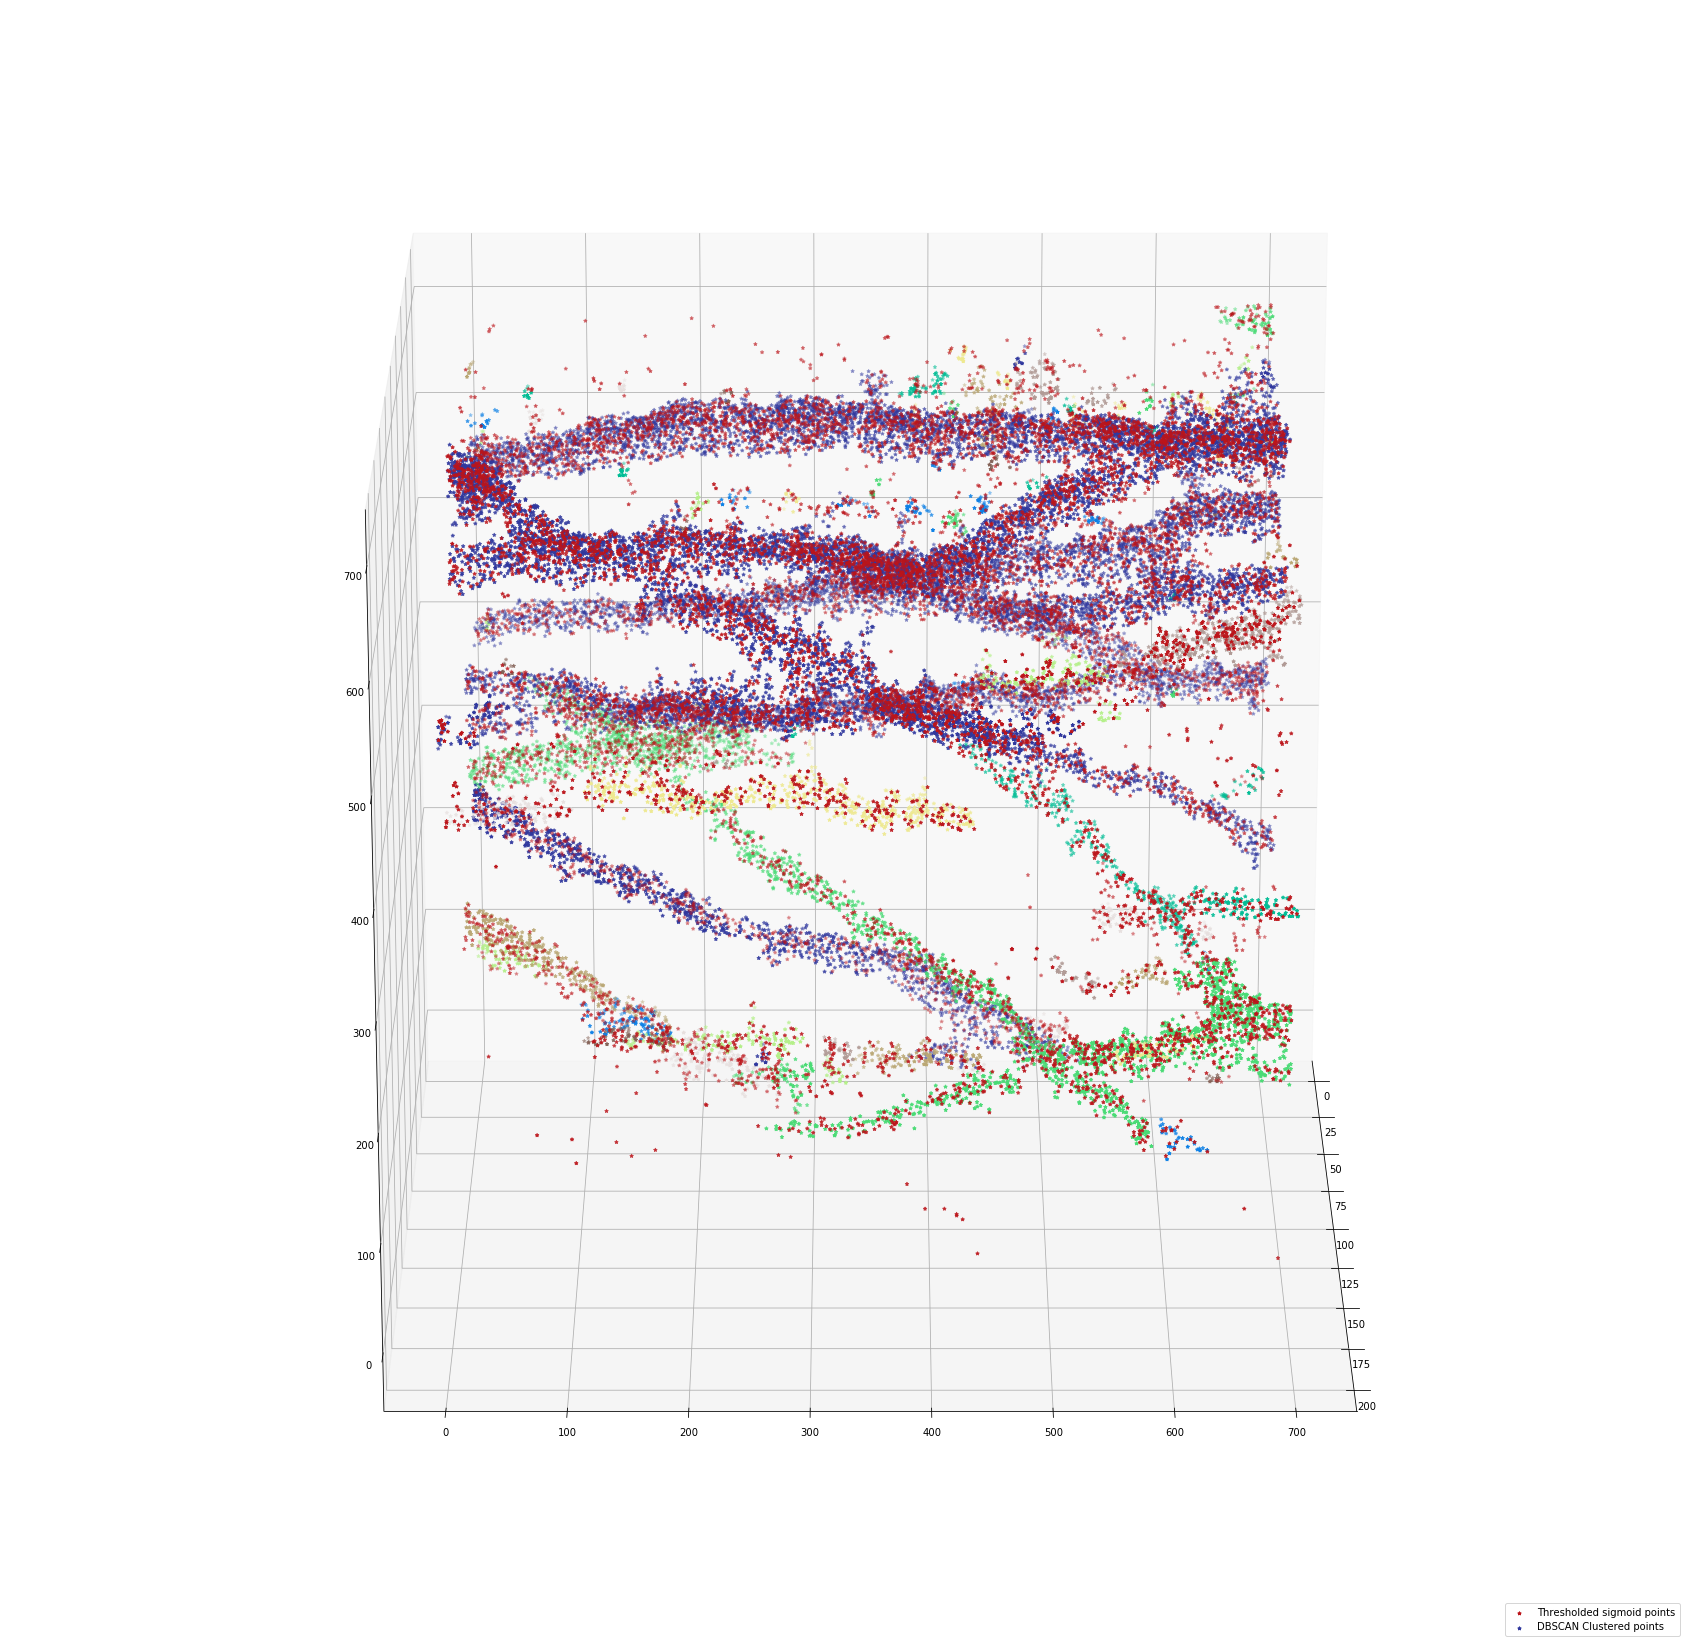

In [15]:
# Draw ROI  Figures

%matplotlib inline
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.cluster import DBSCAN, OPTICS
import matplotlib.cm as cm
import numpy as np

np.random.seed(777)

# maxs_small = makeas(subs,axx[choices],
#                     ay[choices],az[choices])
# axx,ay,az = np.where(maxs_small)




# subs = dd[400:700,100:800,100:800]



mask_maxi = (subs<50).astype(bool)
axx,ay,az = np.where(subs<20)
choices = np.random.choice(axx.shape[0],14000,replace=False)
pred_choices = np.random.choice(axx.shape[0],16000,replace=False)




# ----------------
ponts = np.concatenate((axx[choices].reshape(-1,1),
                        ay[choices].reshape(-1,1),
                        az[choices].reshape(-1,1)),axis=1)

pred_ponts = np.concatenate((axx[pred_choices].reshape(-1,1),
                        ay[pred_choices].reshape(-1,1),
                        az[pred_choices].reshape(-1,1)),axis=1)


model = DBSCAN(eps=10, min_samples=5)
# model = OPTICS(max_eps=15, min_samples=8)


# model.fit(ponts)
# print(set(model.labels_))




predicted_labels = model.fit_predict(pred_ponts)


# predCols = cm.tab10(np.linspace(0,1,80 ))
# predCols[:,-1] = 1
# axes = draw_model_labels(pred_ponts,predicted_labels,
#                   cols= predCols
#                          ,sBall=1,
#                          imgbase= None
#                  )



axx,ay,az = np.where(subs<50)
test_choices = np.random.choice(axx.shape[0],25500,replace=False)

test_ponts = np.concatenate((axx[test_choices].reshape(-1,1),
                        ay[test_choices].reshape(-1,1),
                        az[test_choices].reshape(-1,1)),axis=1)
tested_labels = model.fit_predict(test_ponts)


creds =[[0.8,0.1,0.05,0.3]]
testCols =  cm.terrain(np.linspace(0.01,0.95,10 ))
testCols[:,-1] = 1
creds = cm.Reds(np.linspace(0.8,1,5))



axx,ay,az = np.where(subs<50)
val_choices = np.random.choice(axx.shape[0],12500,replace=False)
val_ponts = np.concatenate((axx[val_choices].reshape(-1,1),
                        ay[val_choices].reshape(-1,1),
                        az[val_choices].reshape(-1,1)),axis=1)

axes = draw_model_labels(val_ponts,np.zeros(val_ponts.shape[0],dtype=int),
                  cols= creds,
                  axes=None,sBall=12,marker='*',
                  imgbase=None,
                         label='Thresholded sigmoid points'
                 )

draw_model_labels(test_ponts,tested_labels,
                  cols= testCols,
                  axes=axes,sBall=12,marker='*',
                  imgbase=None
                    ,label='DBSCAN Clustered points'
                 )

plt.legend(loc='lower right')

# iind = 0
# for jj in [-40, -11, 20, 41 ]:
#     for ii in np.linspace(0,360,8):
#         if (iind%8)==0 and jj%10!=0:
#             ii = 360 - ii 
                
#         axes.view_init(elev=jj, azim=ii )
#         plt.savefig("../imgs/movie__{0}.png" .format(iind,jj,ii) )
#         iind += 1


axes.view_init(elev=20., azim=0)



# cols= cm.viridis(np.linspace(0,1,max(model.labels_)+1  ))
# axes.scatter(axx,ay,az,c=[cols[ml] for ml in model.labels_ ] )


# axes.scatter(axx[choices],ay[choices],
#              az[choices],marker='^',s=0.15,color='red')

* red color represent raw thresholded colors
* cool color tone give cluster labeling

### Actually draw roi *blocks* on a tiff stack


at least drew one...
at least drew two...


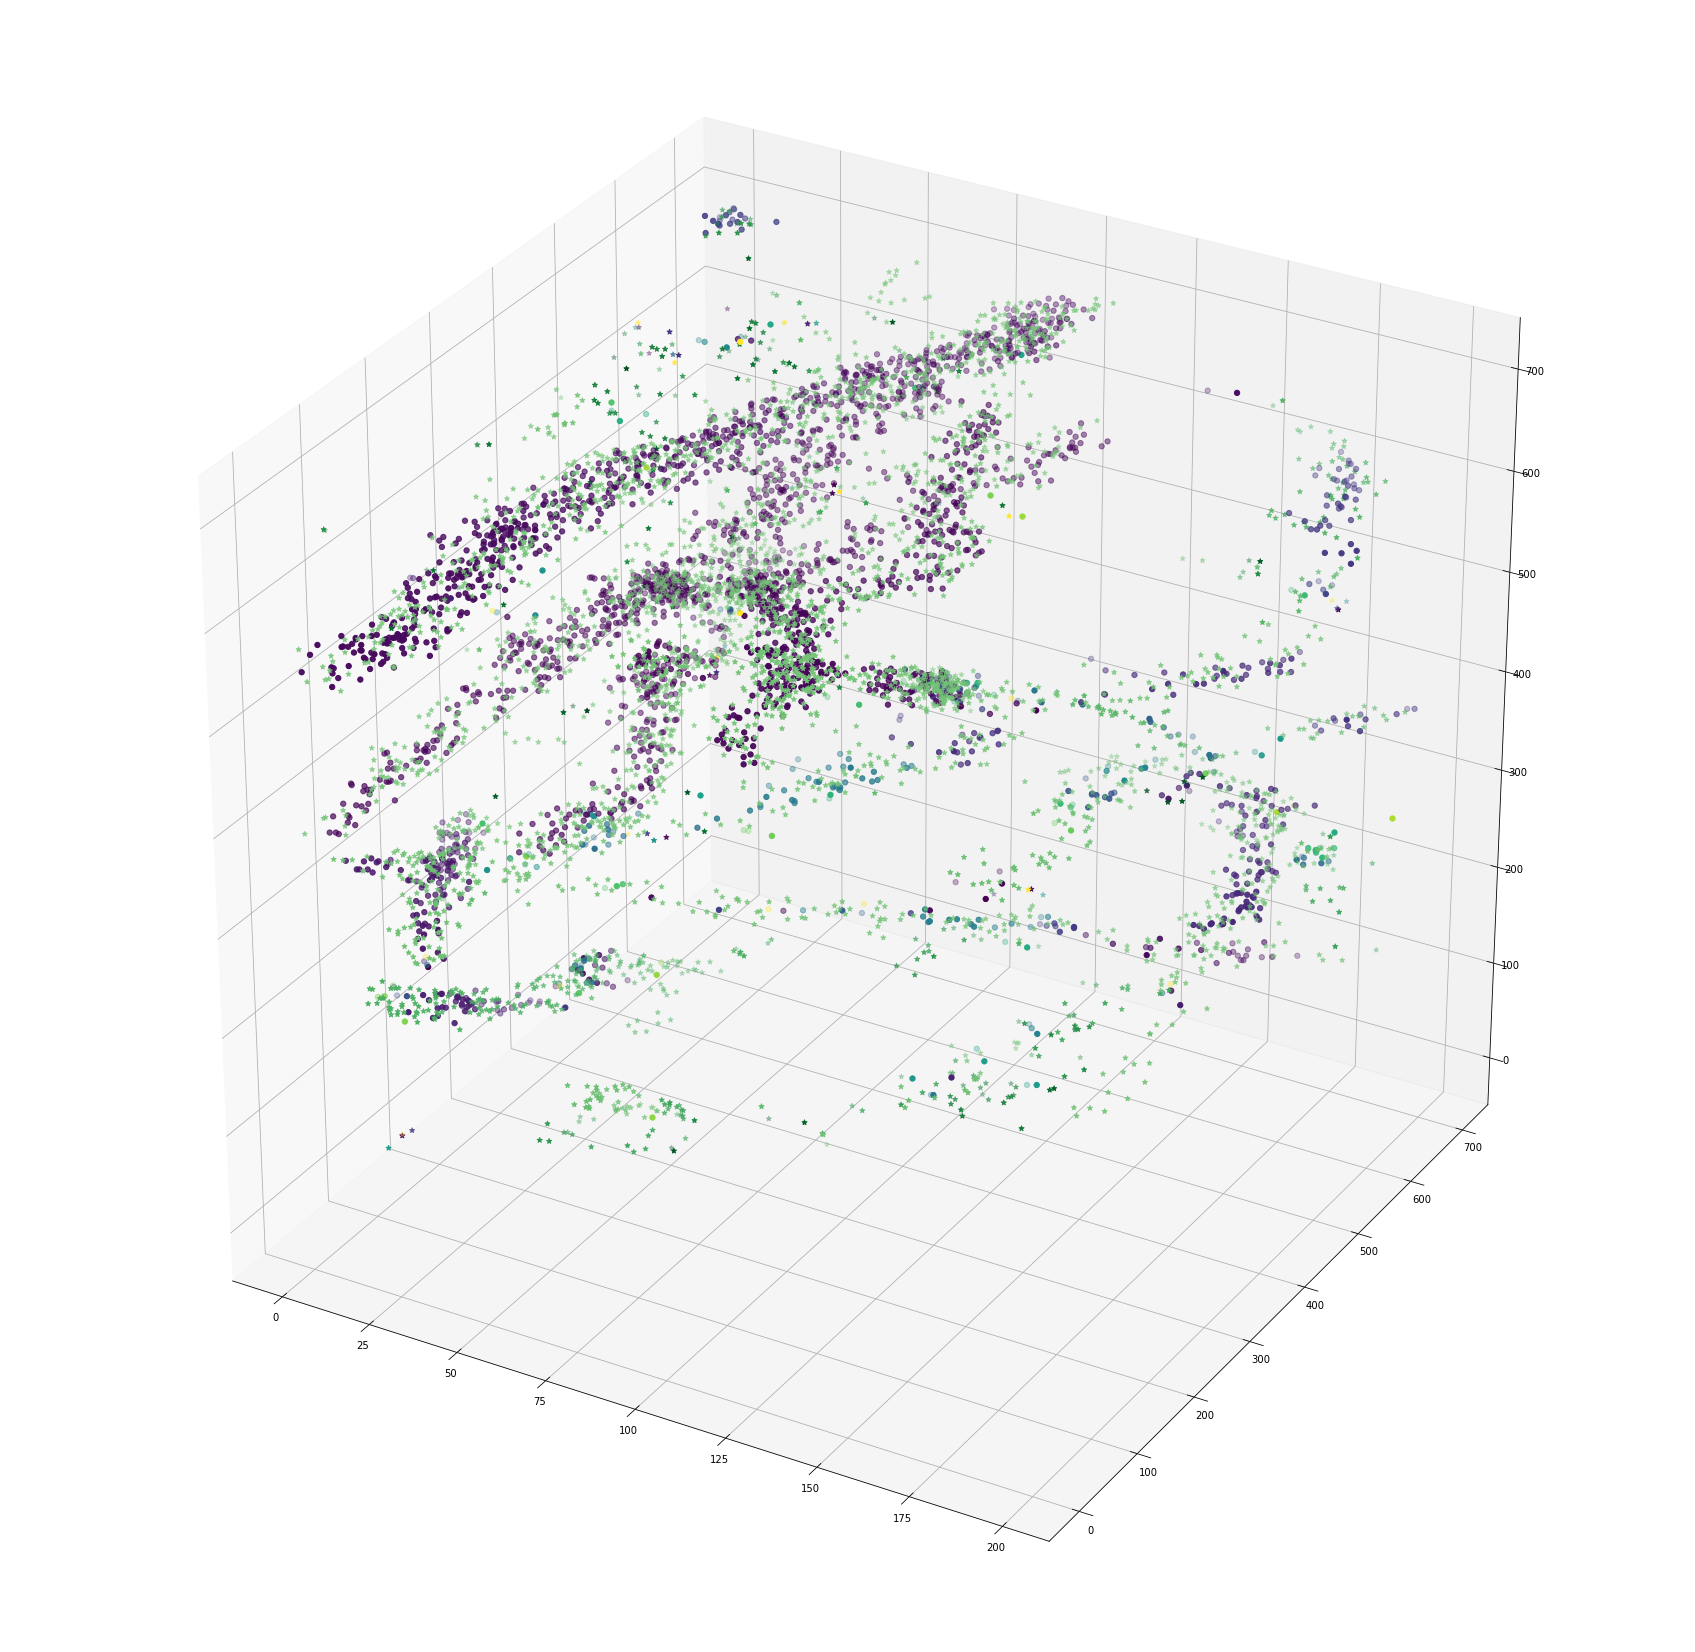

In [17]:
# Actually draw roi *blocks* on a tiff stack

base_draw = np.zeros(subs.shape+(4,),dtype=np.float32)
base_draw[:,:,:,0] = subs.copy()
base_draw[:,:,:,1] = subs.copy()
base_draw[:,:,:,2] = subs.copy()
base_draw[:,:,:,3] = subs.max()

base_draw /= base_draw.max()


axes = draw_model_labels(pred_ponts[:3000],
                         predicted_labels[:3000],
                  cols= cm.viridis(np.linspace(0,1,100))
                         ,sBall=28,
                         imgbase= base_draw,
                         label='dbscan points'
                 )
print('at least drew one...')
# draw_model_labels(val_ponts[:9000],np.zeros(9000,dtype=int),
#                   cols= creds,
#                   axes=axes,sBall=0.5,marker='*',
#                   imgbase=base_draw,
#                   windowspan=3
#                  )
print('at least drew two...')

draw_model_labels(test_ponts[:4000],tested_labels[:4000],
                  cols= cm.Greens(np.linspace(0.5,1,100)),
                  axes=axes,sBall=28,marker='*',
                  imgbase=base_draw,
                  windowspan=2,
                  label='threshold points'
                 )


In [7]:
io.imsave('../data/sub-roipoints.tif',(255*base_draw).astype(np.uint8))

In [ ]:
subs.dtype

### Finding clustering distance distributions

 between 
 1. thresholded points, *top 3 percent of PI**, *>50 PI* <= (sigmoid preprocess)
 1. DBSCAN clustered points, (labels on individual spans(tracks) of *dendrites* ) <= (trained on 1.)
 
 
 *PI -> pixel intensity
 

In [76]:
test_ponts.max(axis=0),test_ponts.min(axis=0)

(array([198, 499, 599]), array([0, 0, 0]))

(array([  58.,  117.,  173.,  194.,  172.,  121.,   88.,   55.,   19.,    3.]),
 array([   5.47722558,   69.05422524,  132.6312249 ,  196.20822457,
         259.78522423,  323.3622239 ,  386.93922356,  450.51622322,
         514.09322289,  577.67022255,  641.24722222]),
 <a list of 10 Patch objects>)

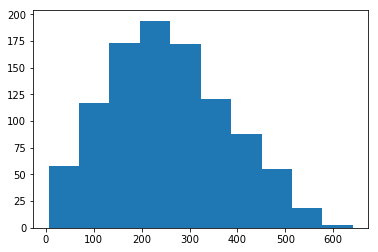

In [20]:
%matplotlib inline

euc_dist = lambda x,y: np.sqrt(np.sum([ (xx-yy)**2  for xx,yy in zip(x,y)]))

dists=[]
for ii in range(1000):
    jj,xx = np.random.choice(5000,2,replace=False)
    dists.append( euc_dist(ponts[jj],ponts[xx])  )
    

plt.hist(dists)

In [17]:
dists

[array([ 6.8556546 ,  7.41619849,  9.79795897]),
 array([ nan,  nan,  nan]),
 array([ 12.4498996 ,          nan,   3.87298335]),
 array([         nan,          nan,  10.77032961]),
 array([        nan,         nan,  4.89897949]),
 array([  9.38083152,  10.77032961,          nan]),
 array([         nan,          nan,  12.36931688]),
 array([  4.24264069,  10.29563014,  18.13835715]),
 array([  8.48528137,          nan,  14.89966443]),
 array([         nan,          nan,  13.03840481]),
 array([ 2.        ,  3.74165739,         nan]),
 array([  2.,  nan,  nan]),
 array([  4.58257569,  14.69693846,  17.34935157]),
 array([         nan,  11.26942767,          nan]),
 array([ 2.44948974,         nan,         nan]),
 array([         nan,          nan,  20.76053949]),
 array([         nan,          nan,  20.46948949]),
 array([  6.8556546 ,  16.        ,  14.83239697]),
 array([         nan,   9.94987437,  15.77973384]),
 array([ 4.58257569,         nan,         nan]),
 array([  6.92820323,  

In [10]:
axx.shape

(5000,)

In [19]:
axx.shape[0]/60018798,subs.shape

(0.03834691924353433, (199, 500, 600))

In [18]:
199*501*602

60018798